In [1]:
import numpy
import math
import datetime
import matplotlib
import scipy.optimize
import pandas
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title
from numpy import log

data = pandas.read_excel('data.xlsx', sheet_name='data')
data['MATURITY_DATE'] = pandas.to_datetime(data['MATURITY_DATE'])
data['ISSUE_DATE'] = pandas.to_datetime(data['ISSUE_DATE'])
data_selected = data.loc[[8, 11, 13, 4, 5, 25, 26, 28, 29, 31],]

data_selected

,ISIN,ISSUE_DATE,MATURITY_DATE,COUPON,0110,0111,0112,0113,0114,0117,0118,0119,0120,0121
8,CA135087L286,2020-05-04,2022-08-01,0.0025,99.800,99.790,99.78,99.770,99.760,99.720,99.700,99.700,99.720,99.740
11,CA135087L773,2020-10-26,2023-02-01,0.0025,99.310,99.260,99.29,99.280,99.260,99.180,99.120,99.100,99.150,99.200
13,CA135087L856,2021-05-14,2023-08-01,0.0025,98.808,98.800,98.78,98.763,98.736,98.610,98.553,98.549,98.558,98.611
4,CA135087J546,2018-10-05,2024-03-01,0.0225,102.310,102.310,102.26,102.220,102.180,101.990,101.910,101.900,101.880,101.970
5,CA135087J967,2019-04-05,2024-09-01,0.0150,100.560,100.630,100.62,100.580,100.520,100.290,100.210,100.150,100.170,100.270
25,CA135087K528,2019-10-11,2025-03-01,0.0125,99.640,99.670,99.61,99.590,99.490,99.250,99.120,99.110,99.100,99.260
26,CA135087K940,2020-04-03,2025-09-01,0.0050,96.660,96.720,96.77,96.770,96.680,96.430,96.260,96.150,96.190,96.310
28,CA135087L518,2020-10-09,2026-03-01,0.0025,95.110,95.170,95.12,95.140,95.040,94.750,94.530,94.500,94.520,94.700
29,CA135087L930,2021-04-16,2026-09-01,0.0100,97.660,97.740,97.67,97.690,97.585,97.240,97.020,96.960,97.000,97.225
31,CA135087M847,2021-10-15,2027-03-01,0.0125,98.410,98.475,98.40,98.440,98.310,97.955,97.700,97.660,97.685,97.940


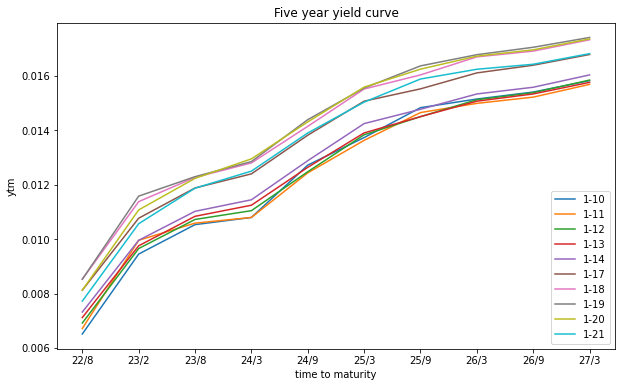

In [2]:
class bond:
    def __init__(self, ISIN, ten_day_price, maturity_date, coupon_rate, time_to_maturity):
        self.ISIN = ISIN
        self.ten_day_price = ten_day_price
        self.maturity_date = maturity_date
        self.coupon_rate = coupon_rate
        self.time_to_maturity = time_to_maturity
        # As the coupon are paid semi-annually
        self.periods = self.time_to_maturity * 2

    def bond_ytm(self, price, par=100, freq=2, x0=0.05):
        coupon_payment = self.coupon_rate * par / freq
        time = [(j + 1) / freq for j in range(int(self.periods))]
        ytm = lambda y: sum([coupon_payment / (1 + y / freq) ** (freq * t) for t in time]) + \
                        par / (1 + y / freq) ** (freq * self.time_to_maturity) - price
        return scipy.optimize.newton(ytm, x0)


price_list = data_selected.iloc[:, 4:].values.tolist()
bonds = []
for i in range(10):
    bonds.append(bond(ISIN=data_selected.iloc[i, 0],
                      ten_day_price=price_list[i],
                      maturity_date=data_selected.iloc[i, 2],
                      coupon_rate=data_selected.iloc[i, 3],
                      time_to_maturity=(i + 1) * 0.5))

ytm_dict = {}
dates = ['1-10', '1-11', '1-12', '1-13', '1-14', '1-17', '1-18', '1-19', '1-20', '1-21']
for i in range(len(dates)):
    ytm_dict[dates[i]] = []
    for bond in bonds:
        bond_ytm = [bond.bond_ytm(price=bond.ten_day_price[i])]
        ytm_dict[dates[i]].append(bond_ytm)
x_label = ['22/8', '23/2', '23/8', '24/3', '24/9', '25/3', '25/9', '26/3', '26/9','27/3']
plt.figure(figsize=(10, 6))
plt.xlabel('time to maturity')
plt.ylabel('ytm')
plt.title('Five year yield curve')

for bond in ytm_dict:
    plt.plot(x_label, ytm_dict[bond])
plt.legend(dates, loc="lower right")

plt.savefig('E:yield_curve.png')


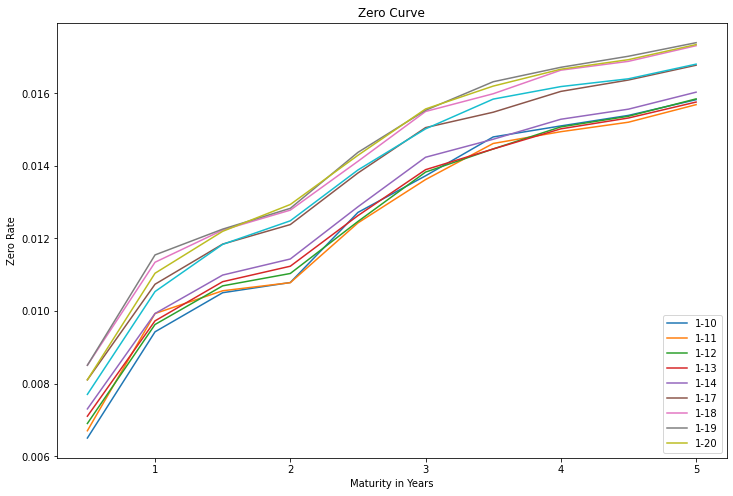

In [3]:
class BootstrapYieldCurve(object):

    def __init__(self):
        self.zero_rates = dict()
        self.instruments = dict()

    def add_instrument(self, par, T, coup, price, compounding_freq=2):
        self.instruments[T] = (par, coup, price, compounding_freq)

    def get_maturities(self):
        """
        :return: a list of maturities of added instruments
        """
        return sorted(self.instruments.keys())

    def get_zero_rates(self):
        """
        Returns a list of spot rates on the yield curve.
        """
        self.bootstrap_zero_coupons()
        self.get_bond_spot_rates()
        return [self.zero_rates[T] for T in self.get_maturities()]

    def bootstrap_zero_coupons(self):
        """
        Bootstrap the yield curve with zero coupon instruments first.
        """
        for (T, instrument) in self.instruments.items():
            (par, coup, price, freq) = instrument
            if coup == 0:
                spot_rate = self.zero_coupon_spot_rate(par, price, T)
                self.zero_rates[T] = spot_rate

    def zero_coupon_spot_rate(self, par, price, T):
        """
        :return: the zero coupon spot rate with continuous compounding.
        """
        spot_rate = math.log(par / price) / T
        return spot_rate

    def get_bond_spot_rates(self):
        """
        Get spot rates implied by bonds, using short-term instruments.
        """
        for T in self.get_maturities():
            instrument = self.instruments[T]
            (par, coup, price, freq) = instrument
            if coup != 0:
                spot_rate = self.calculate_bond_spot_rate(T, instrument)
                self.zero_rates[T] = spot_rate

    def calculate_bond_spot_rate(self, T, instrument):
        try:
            (par, coup, price, freq) = instrument
            periods = T * freq
            value = price
            per_coupon = coup / freq
            for i in range(int(periods) - 1):
                t = (i + 1) / float(freq)
                spot_rate = self.zero_rates[t]
                discounted_coupon = per_coupon * math.exp(-spot_rate * t)
                value -= discounted_coupon

            last_period = int(periods) / float(freq)
            spot_rate = -math.log(value / (par + per_coupon)) / last_period
            return spot_rate
        except:
            print("Error: spot rate not found for T=", t)


maturity_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
zero_rate_dict = {}
for i in range(10):
    zero_rate_dict[maturity_list[i]] = []

fig = plt.figure(figsize=(12, 8))
title("Zero Curve")
ylabel("Zero Rate")
xlabel("Maturity in Years")

for i in range(10):
    yield_curve = BootstrapYieldCurve()
    for bond in bonds:
        yield_curve.add_instrument(par=100,
                                   T=bond.time_to_maturity,
                                   coup=bond.coupon_rate * 100,
                                   price=bond.ten_day_price[i],
                                   compounding_freq=2)
    y = yield_curve.get_zero_rates()

    for j in range(10):
        zero_rate_dict[maturity_list[j]].append(y[j])

    plt.legend(dates, loc="lower right")
    plot(maturity_list, y)
    plt.savefig('E:/zero_curve.png')



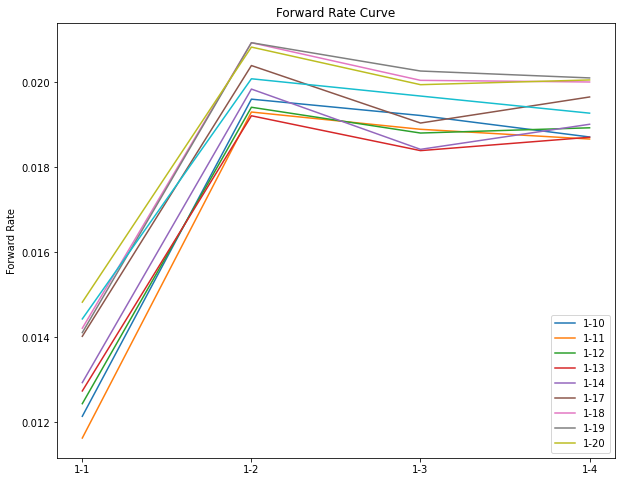

In [4]:
class ForwardRates(object):

    def __init__(self):
        self.forward_rates = []
        self.spot_rates = dict()

    def add_spot_rate(self, T, spot_rate):
        self.spot_rates[T] = spot_rate

    def get_forward_rates(self):
        """
        Returns a list of forward rates
        starting from the second time period.
        """
        periods = sorted(self.spot_rates.keys())
        for T2, T1 in zip(periods, periods[1:]):
            forward_rate = self.calculate_forward_rate(T1, T2)
            self.forward_rates.append(forward_rate)

        return self.forward_rates

    def calculate_forward_rate(self, T1, T2):
        R1 = self.spot_rates[T1]
        R2 = self.spot_rates[T2]
        forward_rate = (R2 * T2 - R1 * T1) / (T2 - T1)
        return forward_rate


fig = plt.figure(figsize=(10, 8))
title("Forward Rate Curve")
ylabel("Forward Rate")
# x_label("Years")
xlabel = ['1-1', '1-2', '1-3', '1-4']

# subset zero rate dict with odd indices only
keys_to_extract = [1.0,2.0,3.0,4.0,5.0]
subset_zero_rate_dict = {key: zero_rate_dict[key] for key in keys_to_extract}
forward_rate_dict = {}

for j in range(10):
    fr = ForwardRates()
    for i in subset_zero_rate_dict:
        fr.add_spot_rate(i, zero_rate_dict[i][j])
    forward = fr.get_forward_rates()
    forward_rate_dict[j] = forward

    plt.legend(dates, loc="lower right")
    plot(xlabel, forward)
    plt.savefig('E:/forward_curve.png')


In [12]:
def flatten(t):
    return [item for sublist in t for item in sublist]

yield_dict = ytm_dict.copy()
for key in ytm_dict:
    yield_dict[key] = yield_dict[key][1::2]
    yield_dict[key] = flatten(yield_dict[key])

yield_df = pandas.DataFrame.from_dict(yield_dict)
log_yield = numpy.empty(shape=45)
for i in range(5):
    yield_i = yield_df.iloc[i,:]
    for j in range(9):
        log_yield_ij = log(yield_i[j+1]/yield_i[j])
        numpy.append(log_yield, log_yield_ij)   
log_yield = log_yield.reshape((5,9))
log_yield_cov = numpy.cov(log_yield)
print(log_yield_cov)
yield_eigen = numpy.linalg.eig(log_yield_cov)
yield_eigenval = yield_eigen[0]
yield_eigenvec = yield_eigen[1]
print("The yield eigenvalues are:")
print(yield_eigenval)
print("The yield eigenvector matrix is:")
print(yield_eigenvec)
forward_df = pandas.DataFrame.from_dict(forward_rate_dict)


0.05220262177974906
-0.030998211934274652
0.01043829781726284
0.020559914117011753
0.07831343343267717
0.055012614500886736
0.017695575681606325
-0.04482987518696478
-0.0468979534720797
0.0
0.022882374268620373
0.017946114494878207
0.017638365162691197
0.0798881875584034
0.03186943350311894
0.003915382230633661
0.007786514617481471
-0.03551123507158106
-0.007502476551936996
0.014951718401477316
0.004936967051505742
0.024342796594601587
0.0562232376363078
0.0292471692366913
0.0022165879723264597
0.0022119483620396075
-0.03595941816606958
-0.010591703667112155
0.008833670313218587
-0.0035247376725123206
0.0175089856842985
0.04921949281449844
0.03589374013853744
0.004803417934244107
-0.0031999049136881876
-0.029234061134992943
-0.008691125043804624
0.0100221099633821
-0.005333688367222298
0.01724024084434565
0.04574262959999202
0.031720978708643495
0.00489404017063885
-0.0030562305274446228
-0.031667332663624745
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 

In [6]:
log_forward = []
for i in range(4):
    forward_i = forward_df.iloc[i,:]
    for j in range(9):
        log_forward_ij = log(forward_i[j+1]/forward_i[j])
        log_forward.append(log_forward_ij)
log_forward = numpy.asarray(log_forward).reshape((4,9))
print("The logged forward matrix is:")
print(log_forward)
log_forward_cov = numpy.cov(log_forward)
print("The logged forward covariance matrix is:")
print(log_forward_cov)


The logged forward matrix is:
[[-4.30580670e-02  6.71568400e-02  2.37920529e-02  1.53096698e-02
   8.08500626e-02  1.34560068e-02 -7.29504175e-03  4.95380330e-02
  -2.69526226e-02]
 [-1.55611041e-02  5.79457548e-03 -1.03817798e-02  3.21838761e-02
   2.75112753e-02  2.60281919e-02 -3.10154936e-05 -4.92089794e-03
  -3.64583781e-02]
 [-1.70368747e-02 -4.67577515e-03 -2.22384563e-02  1.63029546e-03
   3.30398263e-02  5.13947730e-02  1.08840168e-02 -1.59791258e-02
  -1.34943233e-02]
 [-2.58088691e-03  1.40716544e-02 -1.18253135e-02  1.62015880e-02
   3.32103370e-02  1.77777067e-02  4.77434636e-03 -2.37206929e-03
  -3.97397310e-02]]
The logged forward covariance matrix is:
[[0.00172479 0.00051932 0.00028992 0.00053739]
 [0.00051932 0.00051777 0.00040939 0.00044042]
 [0.00028992 0.00040939 0.0006296  0.00035344]
 [0.00053739 0.00044042 0.00035344 0.0004421 ]]


In [8]:
forward_eigen = numpy.linalg.eig(log_forward_cov)
forward_eigenval = forward_eigen[0]
forward_eigenvec = forward_eigen[1]
print("The forward eigenvalues are:")
print(forward_eigenval)
print("The forward eigenvector matrix is:")
print(forward_eigenvec)

The forward eigenvalues are:
[2.33820378e-03 7.72065380e-04 1.68368041e-04 3.56283934e-05]
The forward eigenvector matrix is:
[[-0.79081802 -0.57499373 -0.20662953 -0.03596257]
 [-0.38298505  0.38792827  0.50300105 -0.67068924]
 [-0.30237672  0.66009472 -0.68649406  0.03961289]
 [-0.36945585  0.28839006  0.48272154  0.73980637]]
